In [46]:
%load_ext autoreload
%autoreload 2

import logging

import helpers.dbg as dbg
import helpers.printing as prnt

prnt.config_notebook()

#dbg.init_logger(verbosity=logging.DEBUG)
dbg.init_logger(verbosity=logging.INFO)
# dbg.test_logger()
_LOG = logging.getLogger(__name__)

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-19f59c8f-5ad0-44e1-89ed-7783834804cb.json'


In [49]:
_LOG.debug = _LOG.info

# Generate random data

In [27]:
import numpy as np
import pandas as pd

np.random.seed(42)

#date_range = pd.date_range("09:30", "15:00", freq="1T")
date_range = pd.date_range("09:30", "10:00", freq="1T")

diff = np.random.normal(0, 1, size=len(date_range))
diff = diff.cumsum()
price = 100.0 + diff
df = pd.DataFrame(price, index=date_range, columns=["price"])

# ask, bid
df["ask"] = price + np.abs(np.random.normal(0, 1, size=len(date_range)))
df["bid"] = price - np.abs(np.random.normal(0, 1, size=len(date_range)))
display(df.head(5))

,price,ask,bid
2021-09-08 09:30:00,100.496714,102.348992,99.390379
2021-09-08 09:31:00,100.358450,100.371947,99.162243
2021-09-08 09:32:00,101.006138,102.063849,100.193613
2021-09-08 09:33:00,102.529168,103.351713,101.172928
2021-09-08 09:34:00,102.295015,103.515859,102.223005


## Case 1: instantaneous, no costs

In [82]:
# Sample on 5 minute bars labeling and close on the right

#df_5mins = df.resample("5T", closed="right", label="right").mean()
df_5mins = df.resample("5T", closed="right", label="right").last()

if False:
    a = df.iloc[1:6]["price"].mean()
    b = df_5mins.iloc[1]["price"]
    #print(a, b)
    assert a == b
    
df_5mins["ret_0"] = df_5mins["price"].pct_change()

df_5mins["preds"] = (np.random.random(df_5mins.shape[0]) >= 0.5) * 2.0 - 1.0
display(df_5mins)

,price,ask,bid,ret_0,preds
2021-09-08 09:30:00,100.496714,102.348992,99.390379,NaN,1.0
2021-09-08 09:35:00,102.060878,102.269742,101.057345,0.015564,-1.0
2021-09-08 09:40:00,104.017193,104.188562,103.981367,0.019168,-1.0
2021-09-08 09:45:00,99.592940,100.053579,99.293933,-0.042534,1.0
2021-09-08 09:50:00,98.039678,98.424760,96.561783,-0.015596,1.0
2021-09-08 09:55:00,96.023221,96.862439,95.694470,-0.020568,1.0
2021-09-08 10:00:00,93.753887,93.939545,93.051833,-0.023633,-1.0


<AxesSubplot:>

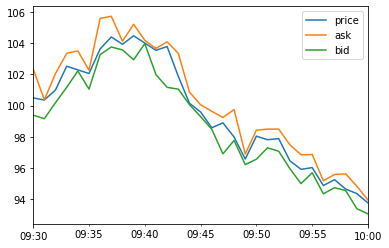

In [15]:
df.plot()

In [84]:
# Naive pnl

w0 = 100.0
w = w0
for ts, row in df_5mins[:-2].iterrows():
    _LOG.debug("ts=%s", ts)
    pred = row["preds"]
    price_5 = df.loc[ts + pd.DateOffset(minutes=5)]["price"]
    price_10 = df.loc[ts + pd.DateOffset(minutes=10)]["price"]
    _LOG.debug("# pred=%s price_5=%s price_10=%s", pred, price_5, price_10)
    # 
    num_shares = w / price_5
    if pred == 1:
        # Go long.
        buy_pnl = num_shares * price_5
        sell_pnl = num_shares * price_10
        diff = -buy_pnl + sell_pnl
    elif pred == -1:
        # Short sell.
        sell_pnl = num_shares * price_5
        buy_pnl = num_shares * price_10
        diff = sell_pnl - buy_pnl
    else:
        raise ValueError
    _LOG.debug("  w=%s num_shares=%s", w, num_shares)
    w += diff
    _LOG.debug("  diff=%s -> w=%s", diff, w)
        
print(w)
print((w - w0) / w0)

# Use lags.
df_5mins["pnl"] = df_5mins["preds"] * df_5mins["ret_0"].shift(-2)
pnls = df_5mins["pnl"][:-1]

print((1 + pnls).prod() - 1)

display(df_5mins[:-1])

ts=2021-09-08 09:30:00
# pred=1.0 price_5=102.06087791467625 price_10=104.0171934241751
  w=100.0 num_shares=0.9798073663799055
  diff=1.9168123471702359 -> w=101.91681234717024
ts=2021-09-08 09:35:00
# pred=-1.0 price_5=104.0171934241751 price_10=99.59294033575907
  w=101.91681234717024 num_shares=0.9798073663799055
  diff=4.334915766759082 -> w=106.25172811392932
ts=2021-09-08 09:40:00
# pred=-1.0 price_5=99.59294033575907 price_10=98.03967754008498
  w=106.25172811392932 num_shares=1.0668600380280107
  diff=1.657114005260354 -> w=107.90884211918967
ts=2021-09-08 09:45:00
# pred=1.0 price_5=98.03967754008498 price_10=96.02322112325758
  w=107.90884211918967 num_shares=1.1006650044832056
  diff=-2.2194430110675256 -> w=105.68939910812215
ts=2021-09-08 09:50:00
# pred=1.0 price_5=96.02322112325758 price_10=93.75388651223948
  w=105.68939910812215 num_shares=1.1006650044832056
  diff=-2.4977771898101366 -> w=103.19162191831201
103.19162191831201
0.03191621918312009
0.03191621918311971


,price,ask,bid,ret_0,preds,pnl
2021-09-08 09:30:00,100.496714,102.348992,99.390379,NaN,1.0,0.019168
2021-09-08 09:35:00,102.060878,102.269742,101.057345,0.015564,-1.0,0.042534
2021-09-08 09:40:00,104.017193,104.188562,103.981367,0.019168,-1.0,0.015596
2021-09-08 09:45:00,99.592940,100.053579,99.293933,-0.042534,1.0,-0.020568
2021-09-08 09:50:00,98.039678,98.424760,96.561783,-0.015596,1.0,-0.023633
2021-09-08 09:55:00,96.023221,96.862439,95.694470,-0.020568,1.0,NaN
